# Importing Libraries

In [4]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

# Importing basic tensorflow libraries
import tensorflow as tf
from tensorflow import keras

# Importing modules for image preprocessing
from PIL import Image

# importing modules for Result Analysis
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# Setting up global random seed
np.random.seed(369)

# importing matplotlib and seeting up the style to use
from matplotlib import style
style.use('fivethirtyeight')

### Setting the Directory for images

In [5]:
data_dir = '../input/gtsrb-german-traffic-sign'
train_path = '../input/gtsrb-german-traffic-sign/Train'
test_path = '../input/gtsrb-german-traffic-sign/'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

### Making a Dataframe with Image system paths as one column and the classes they belong to as labels as another column

In [6]:
# Calculating the number of Classes or Categories
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [7]:
# Printing all the Classes or Categories
classes = os.listdir(train_path)
print(classes)

['7', '17', '19', '22', '2', '35', '23', '10', '5', '36', '20', '27', '41', '39', '32', '25', '42', '8', '38', '12', '0', '31', '34', '18', '28', '16', '13', '26', '15', '3', '1', '30', '14', '4', '9', '21', '40', '6', '11', '37', '33', '29', '24']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  from ipykernel import kernelapp as app


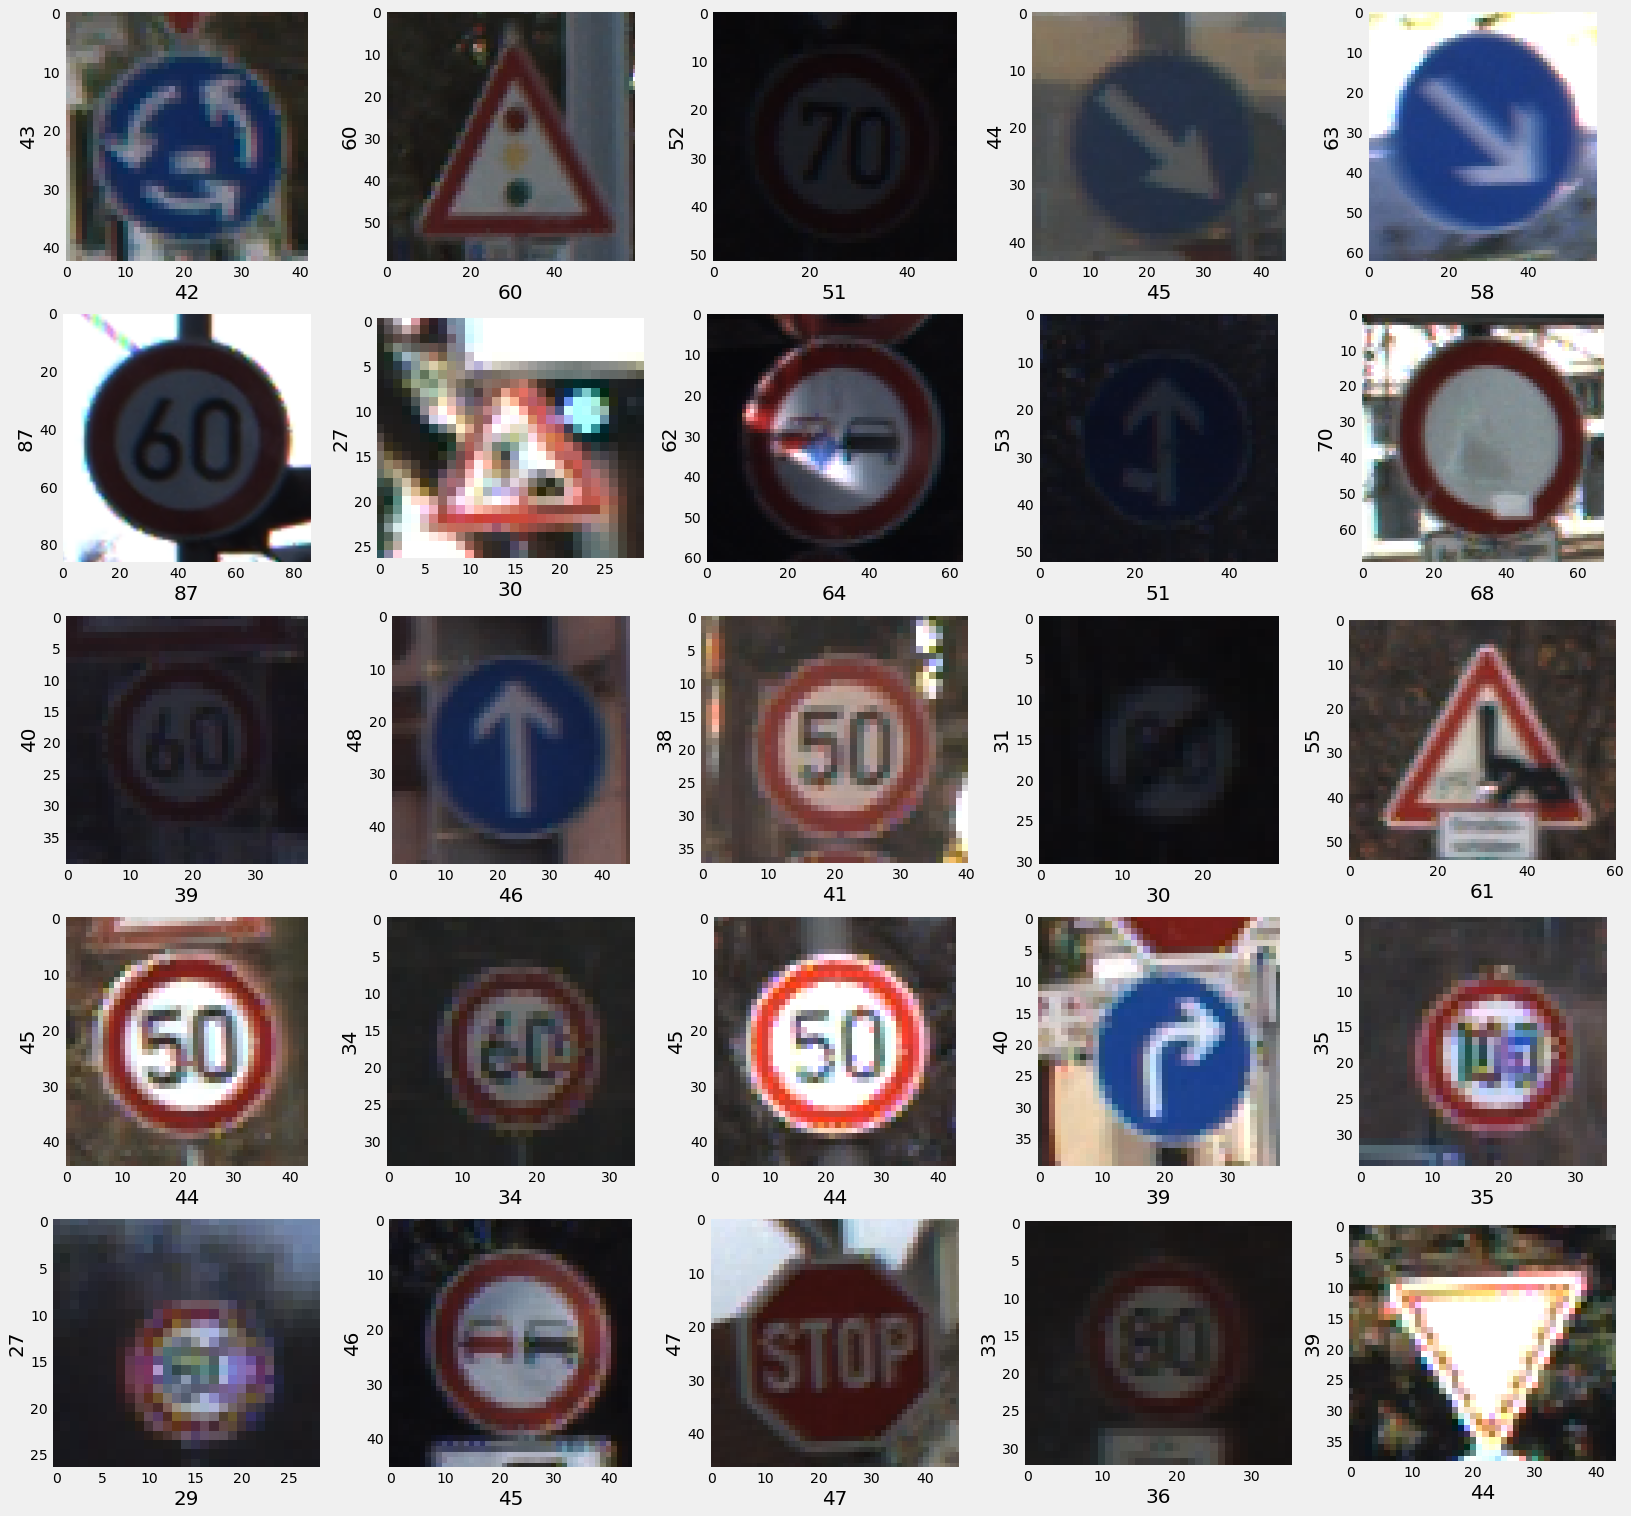

In [8]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [9]:
image_data = [] # Used to store the pixel values on top of each other like a stack in list of list form
image_labels = [] # Used to store the labels for each stacked image pixel values

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        image = cv2.imread(path + '/' + img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        image_data.append(np.array(resize_image))
        image_labels.append(i)
        
# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


# Dividing the dataframe into Train and Test Dataframe

In [10]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 # Normalizing the data to bring pixel values in 0 to 1 range 
X_val = X_val/255 # Normalizing the data to bring pixel values in 0 to 1 range

print(f"X_train.shape: {X_train.shape} X_valid.shape: {X_val.shape} y_train.shape: {y_train.shape} y_valid.shape: {y_val.shape}")

X_train.shape: (27446, 30, 30, 3) X_valid.shape: (11763, 30, 30, 3) y_train.shape: (27446,) y_valid.shape: (11763,)


### One Hot Encoding the catagorical data

In [11]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


# Model Creation

In [15]:
# Creating a Basic CNN model with 4 Convulutional 2D layers and 2 Maxpool2D layers and 3 Batch Normalization Layers
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

# Training the Model

In [16]:
# lr is Learning Rate for the model the optimizer we will use is Adam
lr = 0.001
epochs = 30

opt = Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
# Compile the CNN model with Categorical Crossentropy as our model evaluation method
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [17]:
# Creating a data augmenter
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

# Augenting the dataset and training the model on the augmented dataset for 30 epochs and batch size being 32
history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

2022-11-25 04:29:47.614138: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
858/858 [==============================] - 42s 47ms/step - loss: 0.9989 - accuracy: 0.7331 - val_loss: 0.0800 - val_accuracy: 0.9770
Epoch 2/30
858/858 [==============================] - 40s 47ms/step - loss: 0.1718 - accuracy: 0.9486 - val_loss: 0.0425 - val_accuracy: 0.9887
Epoch 3/30
858/858 [==============================] - 40s 46ms/step - loss: 0.1046 - accuracy: 0.9680 - val_loss: 0.0454 - val_accuracy: 0.9883
Epoch 4/30
858/858 [==============================] - 41s 48ms/step - loss: 0.0772 - accuracy: 0.9752 - val_loss: 0.0445 - val_accuracy: 0.9876
Epoch 5/30
858/858 [==============================] - 39s 45ms/step - loss: 0.0666 - accuracy: 0.9808 - val_loss: 0.0351 - val_accuracy: 0.9884
Epoch 6/30
858/858 [==============================] - 39s 45ms/step - loss: 0.0537 - accuracy: 0.9826 - val_loss: 0.0109 - val_accuracy: 0.9973
Epoch 7/30
858/858 [==============================] - 38s 45ms/step - loss: 0.0505 - accuracy: 0.9847 - val_loss: 0.0357 - val_accuracy:

# Results

In [18]:
# Evaluating the model using the Test folder for evaluation
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]
# importing and stacking images 
for img in imgs:
    
    image = cv2.imread(data_dir + '/' +img)
    image_fromarray = Image.fromarray(image, 'RGB')
    resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
    data.append(np.array(resize_image))
    
X_test = np.array(data)
X_test = X_test/255
# predict the Class of the image using our model
pred = model.predict(X_test).argmax(axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  98.80443388756927


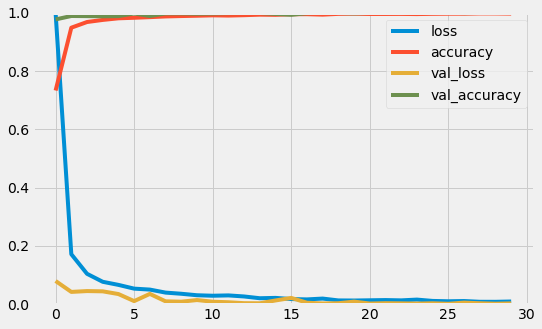

In [19]:
# Ploting a graph for our model performance
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

<AxesSubplot:>

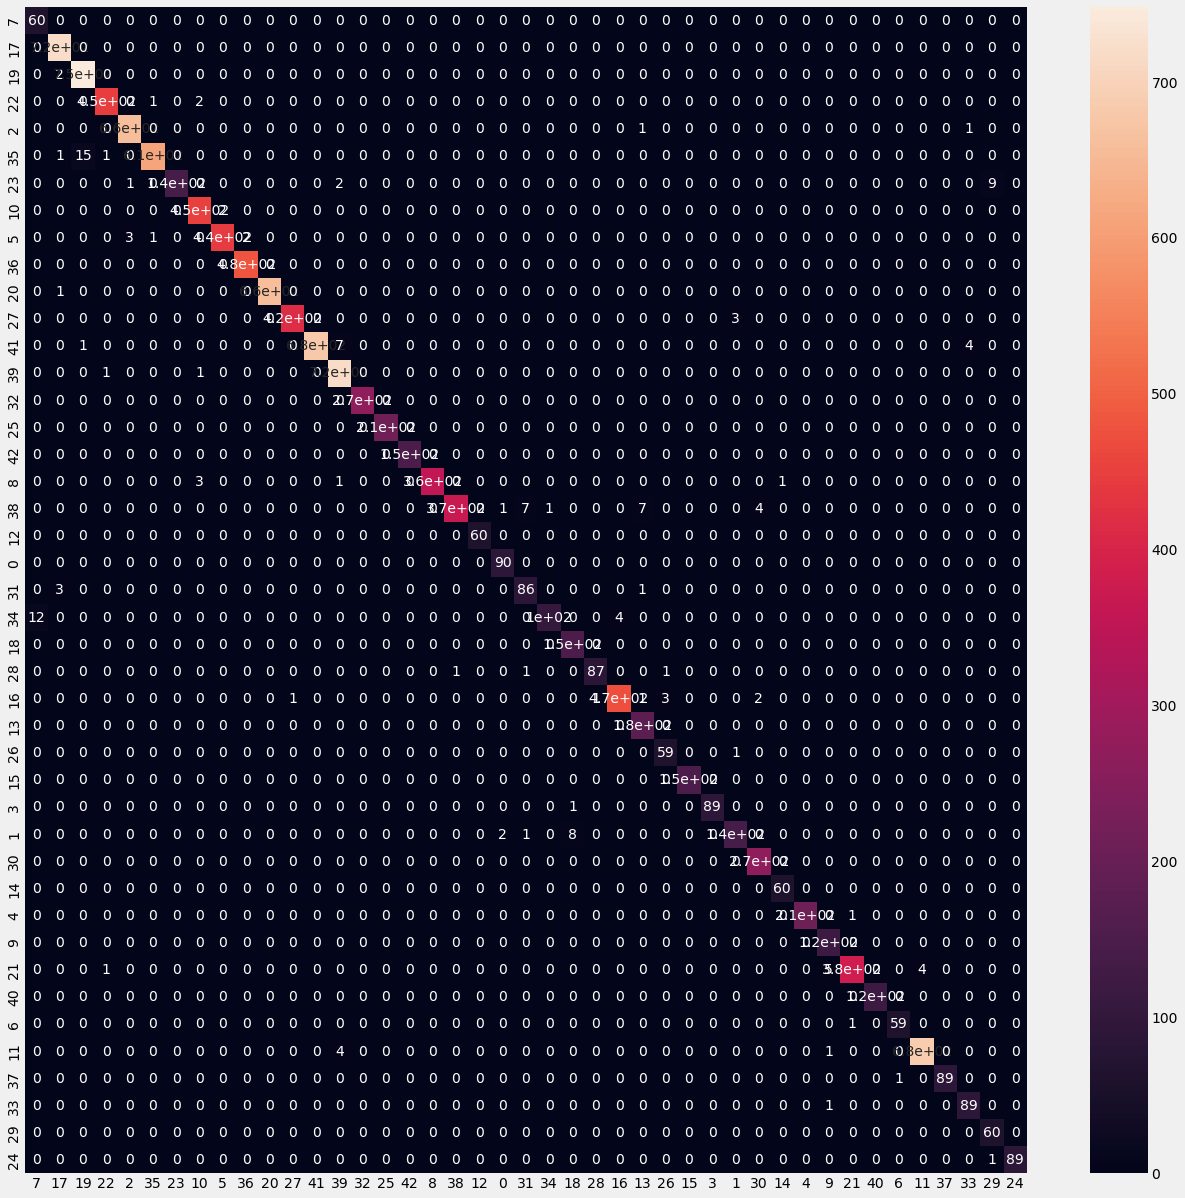

In [20]:
# creating a Confusion matrix for evaluation
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)